<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Conv/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer Learning

### Imports 

In [1]:
import torch
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data.dataset import Subset
from torchvision import transforms
from torch.utils.data import DataLoader

#######################################
### PRE-TRAINED MODELS AVAILABLE HERE
## https://pytorch.org/docs/stable/torchvision/models.html
from torchvision import models
#######################################

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


### Example dataset

In [10]:
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

NUM_CLASSES = 10

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50
BATCH_SIZE = 256

# Architecture
NUM_CLASSES = 10

Device: cuda:0


In [3]:
######### IMPORTANT! ##############

# Check and use the normalization scheme that was used for the
# pre-trained model.

train_indices = torch.arange(0, 49000)
valid_indices = torch.arange(49000, 50000)




train_and_valid = datasets.CIFAR10(root='data', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

train_dataset = Subset(train_and_valid, train_indices)
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          shuffle=True)



train_mean = []
train_std = []

for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean:', train_mean)
print('Std Dev:', train_std)


custom_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=train_mean, std=train_std)])

####################################

Extracting data/cifar-10-python.tar.gz to data
Mean: tensor([0.4914, 0.4821, 0.4465])
Std Dev: tensor([0.2468, 0.2433, 0.2613])


In [4]:
### CIFAR-10 Dataset
##########################


# Note transforms.ToTensor() scales input images
# to 0-1 range


train_indices = torch.arange(0, 49000)
valid_indices = torch.arange(49000, 50000)


train_and_valid = datasets.CIFAR10(root='data', 
                                   train=True, 
                                   transform=custom_transform,
                                   download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)


test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=custom_transform)


#####################################################
### Data Loaders
#####################################################

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

#####################################################

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])


### Loading the pre-trained model

In [5]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freezing the Model

In [6]:
for param in model.parameters():
    param.requires_grad = False

Assume we want to train the penultimate layer:

In [7]:
model.classifier[3].requires_grad = True

Now replace the output layer with your own output layer

In [8]:
model.classifier[6] = nn.Linear(4096, NUM_CLASSES)

## Training

In [11]:
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

In [12]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

# use random seed for reproducibility (here batch shuffling)
torch.manual_seed(RANDOM_SEED)

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/192 | Cost: 2.6318
Epoch: 001/050 | Batch 120/192 | Cost: 1.3168
Epoch: 001/050 Train Acc.: 59.99% | Validation Acc.: 58.50%
Time elapsed: 0.42 min
Epoch: 002/050 | Batch 000/192 | Cost: 1.1441
Epoch: 002/050 | Batch 120/192 | Cost: 1.2748
Epoch: 002/050 Train Acc.: 60.42% | Validation Acc.: 58.50%
Time elapsed: 0.85 min
Epoch: 003/050 | Batch 000/192 | Cost: 1.1461
Epoch: 003/050 | Batch 120/192 | Cost: 1.0259
Epoch: 003/050 Train Acc.: 60.63% | Validation Acc.: 55.20%
Time elapsed: 1.28 min
Epoch: 004/050 | Batch 000/192 | Cost: 1.0998
Epoch: 004/050 | Batch 120/192 | Cost: 1.0782
Epoch: 004/050 Train Acc.: 60.46% | Validation Acc.: 59.00%
Time elapsed: 1.73 min
Epoch: 005/050 | Batch 000/192 | Cost: 1.2197
Epoch: 005/050 | Batch 120/192 | Cost: 1.2216
Epoch: 005/050 Train Acc.: 60.54% | Validation Acc.: 56.90%
Time elapsed: 2.18 min
Epoch: 006/050 | Batch 000/192 | Cost: 1.1381
Epoch: 006/050 | Batch 120/192 | Cost: 1.0972
Epoch: 006/050 Train Acc.: 60.69%

In [13]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 57.84%


In [14]:
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

logits = model(features.to(DEVICE))
_, predicted_labels = torch.max(logits, 1)

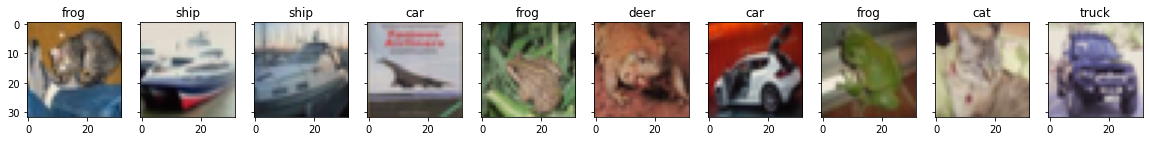

In [15]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

n_images = 10

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225])) 
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])